In [1]:
import random
import torch

words = open('names.txt', 'r').read().splitlines()
words = list(set(words))
random.seed(42)
random.shuffle(words)
len(words)

chs = list(set(''.join(words + ['.'])))
chs = sorted(chs, reverse=False)
stoi = {ch: i for i, ch in enumerate(chs)}
itos = {i: ch for i, ch in enumerate(chs)}

# predict next token use previous 3 tokens
X, Y = [], []

for w in words:
    context = '...'
    for ch in w + '.':
        x = [stoi[c] for c in context]
        y = stoi[ch]
        X.append(x)
        Y.append(y)
        context = context[1:] + ch

X = torch.tensor(X)
Y = torch.tensor(Y)
n1, n2  = int(0.8 * len(X)), int(0.9 * len(X))

X_train, X_val, X_test = X.tensor_split([n1, n2])
Y_train, Y_val, Y_test = Y.tensor_split([n1, n2])

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape


(torch.Size([169062, 3]),
 torch.Size([21133, 3]),
 torch.Size([21133, 3]),
 torch.Size([169062]),
 torch.Size([21133]),
 torch.Size([21133]))

# MLP from tiny_torch

In [2]:
from tiny_torch import *

class MLP(Module):
    def __init__(self, vocab_size, block_size, n_embd, n_hidden, n_layer, dtype=torch.float64, generator=None):
        layers = [Embedding(vocab_size, n_embd, dtype=dtype, generator=generator), Flatten(), Linear(n_embd * block_size, n_hidden, bias=False, dtype=dtype, generator=generator), BatchNorm1d(n_hidden, dtype=dtype), Tanh()]
        for _ in range(n_layer-2):
            layers.extend([Linear(n_hidden, n_hidden, bias=False, dtype=dtype, generator=g), BatchNorm1d(n_hidden, dtype=dtype), Tanh()])
        layers.extend([Linear(n_hidden, vocab_size, bias=False, dtype=dtype, generator=g), BatchNorm1d(vocab_size, dtype=dtype)])
        layers[-1].weight.data *= 0.1
        self.net = Sequential(layers)
        self.block_size = block_size

    def parameters(self):
        return self.net.parameters()
    
    def grads(self):
        return self.net.grads()

    def __call__(self, x):
        return self.net(x)

    def backward(self, grad):
        grad = self.net.backward(grad)
        return grad # None
    
    def eval(self):
        for l in self.net.layers:
            l._training = False

    def train(self):
        for l in self.net.layers:
            l._training = True

    def generate(self, s, max_new_tokens, do_sample=True, temperature=1.0):
        assert isinstance(s, str), 'str in, str out'
        assert len(s) == self.block_size, 'input string length must be equal to block size'
        x = torch.tensor([[stoi[ch] for ch in s]])
        for _ in range(max_new_tokens):
            cond = x[:, -self.block_size:]
            logits = self(cond) * (1 / temperature)
            probs = logits.softmax(dim=-1)
            if do_sample:
                next_x = torch.multinomial(probs, num_samples=1)
            else:
                next_x = probs.argmax(dim=-1, keepdim=True)
            x = torch.cat([x, next_x], dim=-1)
            if next_x.item() == 0:
                break
        s = ''.join([itos[idx.item()] for idx in x[0]])
        return s



In [3]:
g = torch.Generator().manual_seed(42)
n_embd = 10
n_hidden = 200
vocab_size = 27
block_size = 3
n_layer = 5
dtype = torch.float64
eval_interval = 1000
bs = 32
n_steps = 200000
ini_lr = 1.0
lossis = []

# model
model = MLP(vocab_size, block_size, n_embd, n_hidden, n_layer, dtype, generator=g)
loss_fn = CrossEntropyLoss()
optimizer = SGD(model, ini_lr)


torch.manual_seed(42)
model.train()
for step in range(n_steps):
    lr = ini_lr if step < n_steps // 2 else ini_lr / 10
    optimizer.lr = lr
    idx = torch.randint(0, X_train.shape[0], (bs,))
    x, y = X_train[idx], Y_train[idx]

    # forward
    logits = model(x)
    loss = loss_fn(logits, y)

    # backward
    # since grad buffer is stored in model class, we need to call backward imediately after forward
    # otherwise, grad buffer will be overwritten by next forward
    h_grad = loss_fn.backward(grad=1.0) # last layer, dloss=1.0
    model.backward(h_grad)
    
    # update
    optimizer.step()
    optimizer.zero_grad()

    # eval
    if step % eval_interval == 0: 
        model.eval()
        x, y = X_val, Y_val
        logits = model(x)
        val_loss = loss_fn(logits, y) # val loss is actually one step later than train loss
        print(f'step: {step}, train loss: {loss.item()}, val loss: {val_loss.item()}')
        model.train()
    lossis.append(loss.log10().item())
    

step: 0, train loss: 3.286620592003573, val loss: 3.248329129630159
step: 1000, train loss: 2.246682647427437, val loss: 2.5985996015600286
step: 2000, train loss: 2.3004757478624236, val loss: 2.404872577749361
step: 3000, train loss: 2.197385077291087, val loss: 2.3587877215738473
step: 4000, train loss: 2.1687983321972806, val loss: 2.329284204692044
step: 5000, train loss: 2.5151328692674406, val loss: 2.302424986686258
step: 6000, train loss: 2.192216052506786, val loss: 2.288801240474051
step: 7000, train loss: 2.220598983433295, val loss: 2.284478782053658
step: 8000, train loss: 2.277750951337345, val loss: 2.2837481007850555
step: 9000, train loss: 2.0312297119358855, val loss: 2.278029146458778
step: 10000, train loss: 2.1306061467418522, val loss: 2.253269463639488
step: 11000, train loss: 2.070490833343591, val loss: 2.2621505186612003
step: 12000, train loss: 2.2495698538902045, val loss: 2.233078827240398
step: 13000, train loss: 2.0420655148628617, val loss: 2.2319913791

In [4]:
model.eval()
x, y = X_test, Y_test
logits = model(x)
test_loss = loss_fn(logits, y).item()
print(f'test loss: {test_loss}')

torch.manual_seed(42)
for _ in range(10):
    out = model.generate('...', max_new_tokens=10, do_sample=True, temperature=0.5)
    print(out)



test loss: 2.1029920974466276
...anuel.
...matie.
...aarian.
...dan.
...shan.
...silvin.
...ariel.
...mari.
...anne.
...jacquel.


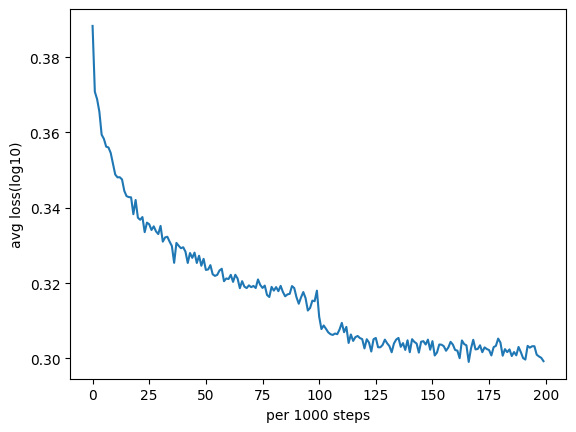

In [5]:
import matplotlib.pyplot as plt

avg_step = 1000
plt.plot(torch.tensor(lossis).view(-1, avg_step).mean(dim=1))
plt.xlabel(f'per {avg_step} steps')
plt.ylabel('avg loss(log10)')
plt.show()


